In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import pi, sin, cos, dot

In [2]:
class TF:
    def __init__(self, n, d):
        self.index = n
        self.thickness = d
        
    def matrix(self, w):
        delta = 2*pi*(self.index)*(self.thickness)/w
        ita = self.index
        element = pd.DataFrame(
            {'e1':cos(delta), 'e2':1j/ita*sin(delta), 'e3':1j*ita*sin(delta), 'e4':cos(delta)}
        )
        matrix = np.reshape(element.values.reshape(1,-1), (np.size(w), 2, 2))
        return matrix
    
def Matrix_dot(layer_up, layer_bot): 
    w, _, _ = np.shape(layer_up)
    eq = [dot(layer_up[i], layer_bot[i]) for i in range(w)]
    return eq

def Eq_TF_Matrix(design):
    eq_matrix = design.pop()
    for i in design:
        eq_matrix = Matrix_dot(design.pop(), eq_matrix)
    return eq_matrix

def Eq_admittance(eq, ns):
    d, _, _ = np.shape(eq)
    eq_y = dot(eq, np.array([[1], [ns]])) 
    Eq_y = pd.DataFrame(np.reshape(eq_y, (d, 2)), columns = ['B','C'])
    Y = Eq_y['C']/Eq_y['B']
    return Y.values.reshape(d, 1)
    
def Reflectance(eq, ns, n0):
    eq_Y = Eq_admittance(eq, ns)
    r = (n0-eq_Y)/(n0+eq_Y)
    R = np.reshape(r*r.conjugate(), np.size(eq_Y))
    return np.real(R)

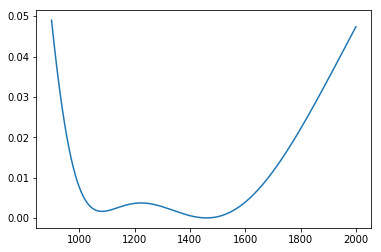

In [3]:
target_w = np.linspace(900,2000, 1000)
layer1 = TF(2.1, 288.67).matrix(target_w)
layer2 = TF(1.42, 223.67).matrix(target_w)
tf_matrix = Eq_TF_Matrix([layer2,layer1])
substrate = 1.8
air = 1

R = Reflectance(tf_matrix, substrate, air)
plt.plot(target_w, R)
plt.show()

In [4]:
def derivative(f1, f2, dx):
    return (f2 - f1)/dx

def FoM(hofx, target):
    merit = sum(abs(hofx-target))
    return merit

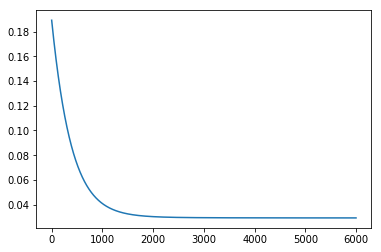

In [5]:
w_target = np.linspace(1350, 1550)
R_target = np.zeros(np.size(w_target))
m = np.size(w_target)
d1 = 300 # inital thickness
d2 = 200
substrate1 = 1.8
ambient1 = 1
n_layer1 = 2.1
n_layer2 = 1.42
step = 10**(-8)
cost = []
costi = []
d_i = []
for i in range(6000):
    alpha1 = 3
    alpha2 = 3
    ####
    layer1 = TF(n_layer1, d1).matrix(w_target)
    layer2 = TF(n_layer2, d2).matrix(w_target)
    tf_matrix = Eq_TF_Matrix([layer2, layer1])
    
    layer1_dx = TF(n_layer1, d1+step).matrix(w_target)
    tf_matrix_dx1 = Eq_TF_Matrix([layer2, layer1_dx])
    
    layer2_dx = TF(n_layer2, d2+step).matrix(w_target)
    tf_matrix_dx2 = Eq_TF_Matrix([layer2_dx, layer1])
           
    R_hofx = Reflectance(tf_matrix, substrate1, ambient1)
    R_hofx_dx1 = Reflectance(tf_matrix_dx1, substrate1, ambient1)
    R_hofx_dx2 = Reflectance(tf_matrix_dx2, substrate1, ambient1)
    
    J = FoM(R_hofx, R_target)
    J_dx1 = FoM(R_hofx_dx1, R_target)
    J_dx2 = FoM(R_hofx_dx2, R_target)
    ###    
    Grad_J1 = derivative(J, J_dx1, step)
    Grad_J2 = derivative(J, J_dx2, step)
    #print(J, J_dx)
    #print(Grad_J)
    #print(Grad_J)
    d1 = d1-alpha1*Grad_J1
    d2 = d2-alpha2*Grad_J2
    cost.append(J)
    costi.append(i)
    d_i.append([d1,d2])
plt.plot(costi, cost)
plt.show()

In [6]:
print(d_i[-1])

[288.5358329405924, 224.4488589071921]
